# Classificação de Imagens Utilizando Redes Neurais Convolucionais

#### Dados balanceados

## Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
import os
import shutil
import locale
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import resample
from tensorflow.keras.models import Model
from sklearn.metrics import precision_recall_curve,average_precision_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D,Dropout

#
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

seed_value = 42
tf.random.set_seed(seed_value)

## Carregando o script com funções do tcc
import functions_tcc  ## Importação das funções usadas no script
function_tcc = functions_tcc.func_tcc()

## Caminhos da base de dados

Com a ideia de aumentarmos a produtividade durante a aplicação do código, iremos definir de inicio os caminhos das pastas com os arquivos em variáveis.

In [2]:
train = 'Dados\\chest_xray_balanceado\\train'
test  = 'Dados\\chest_xray_balanceado\\test'
valid = 'Dados\\chest_xray_balanceado\\val'

Contagem de dados

In [3]:
quant_train = {
    'Categoria': ['Normal','Pneumonia'],
    'Quantidade': [len(os.listdir(os.path.join(train, 'NORMAL'))),len(os.listdir(os.path.join(train, 'PNEUMONIA')))]
}

quant_test = {
    'Categoria': ['Normal','Pneumonia'],
    'Quantidade': [len(os.listdir(os.path.join(test, 'NORMAL'))),len(os.listdir(os.path.join(test, 'PNEUMONIA')))]
}

quant_val = {
    'Categoria': ['Normal','Pneumonia'],
    'Quantidade': [len(os.listdir(os.path.join(valid, 'NORMAL'))),len(os.listdir(os.path.join(valid, 'PNEUMONIA')))]
}

quant_train = pd.DataFrame(quant_train)
quant_test = pd.DataFrame(quant_test)
quant_val = pd.DataFrame(quant_val)

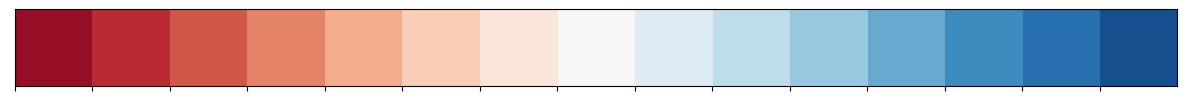

In [4]:
colors = sns.color_palette("RdBu", 15)
sns.palplot(colors)

color_pallete = []
color_pallete.append([colors[14],colors[2]])

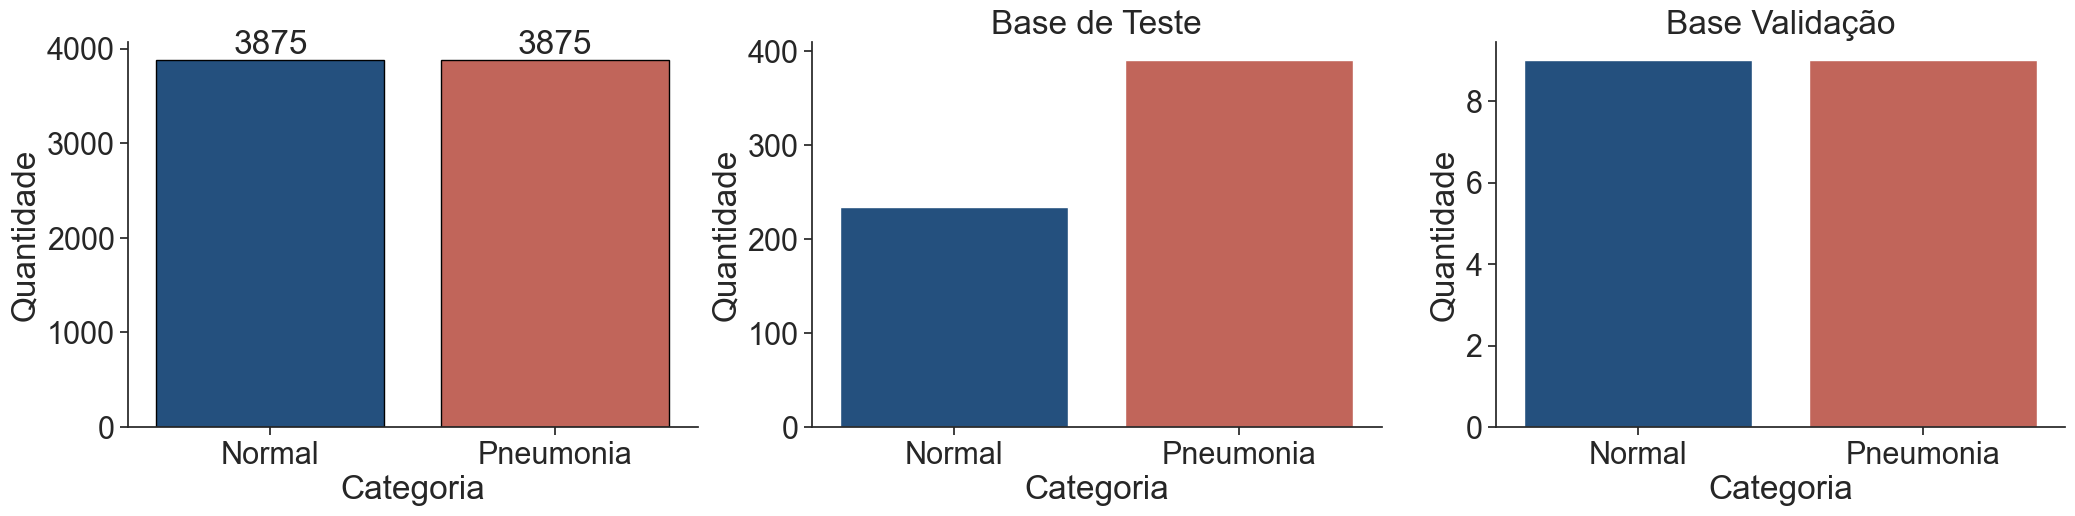

In [5]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette=color_pallete[0], font_scale=2)
#sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(1,3, figsize = (25,5))

# Gráfico base treino
sns.barplot(data = quant_train, x = quant_train['Categoria'], y = quant_train['Quantidade'], ax=ax[0],edgecolor="black", linewidth=1)
# ax[0].set_title('Base de Treino')
for index, row in quant_train.iterrows():
    ax[0].annotate(str(row['Quantidade']), (index, row['Quantidade']), ha='center', va='bottom')
# Gráfico base teste
sns.barplot(data = quant_test, x = quant_test['Categoria'], y = quant_test['Quantidade'], ax=ax[1])
ax[1].set_title('Base de Teste')

# Gráfico base validação
sns.barplot(data = quant_val, x = quant_val['Categoria'], y = quant_val['Quantidade'], ax=ax[2])
ax[2].set_title('Base Validação')


plt.show()

In [6]:
quant_train

,Categoria,Quantidade
0,Normal,3875
1,Pneumonia,3875


*Vemos uma quantidade bem superior no banco de dados de treinamento para a classe Pneumonia, para tentarmos melhorar esta situação iremos aplicar a metodologia de oversampling, onde basicamente iremos utilizar a técnica de data argumantation para aumentarmos a quantidade de imagens da classe 'Normal'.*

*Uma maneira prática de aplicar algoritmos de data argumantation é utilizando a biblioteca albumentations, a partir de comandos simples podemos criar várias versões de imagens aplicando um recorte, mudança de brilho e contraste, efeitos de blur e etc.*

link: https://albumentations.ai/docs/

#### Avaliando o método a partir de uma única imagem

> Carregando uma imagem qualquer

In [6]:
normal = 'Dados\\chest_xray_desbalanceado\\train\\Normal'
imagem = function_tcc.amostragem(normal,n=1)[0]
imagem

'Dados\\chest_xray_desbalanceado\\train\\Normal\\normal_481.jpeg'

(-0.5, 1857.5, 1479.5, -0.5)

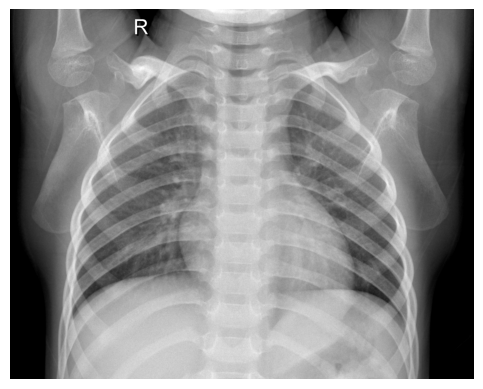

In [7]:
img = function_tcc.leitura(imagem,'normal')
plt.imshow(img)
plt.axis('off')

> Aplicando algumas transformações pelo método de data argumentation

In [8]:
img_t1 = function_tcc.transforma()
img_t2 = function_tcc.transforma()
img_t3 = function_tcc.transforma()

> Plotando as imagens

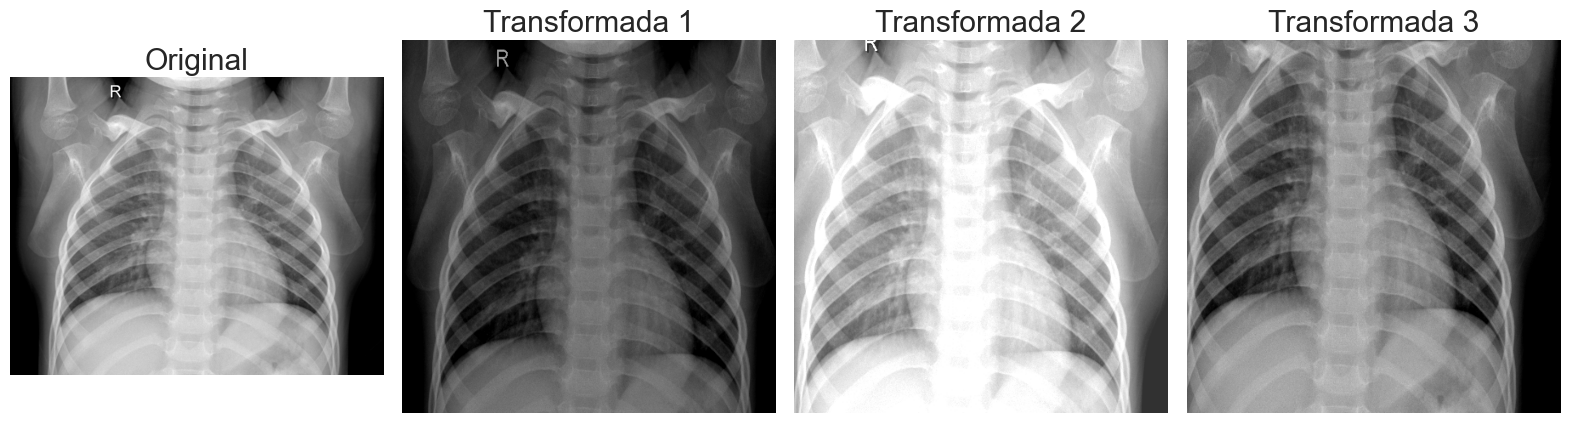

In [9]:
sns.set_theme(style="ticks", rc=custom_params, palette=color_pallete[0], font_scale=1.8)
fig, ax = plt.subplots(1,4, figsize = (20,20))
plt.subplots_adjust(wspace=0.05)

ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(img_t1)
ax[1].set_title('Transformada 1')
ax[1].axis('off')

ax[2].imshow(img_t2)
ax[2].set_title('Transformada 2')
ax[2].axis('off')

ax[3].imshow(img_t3)
ax[3].set_title('Transformada 3')
ax[3].axis('off')

plt.show()

## Aplicando o oversampling

*Para a aplicação iremos usar uma amostra de 845 imagens do banco de imagens da classe **Normal**, que correspondem a um total de 1341, ou seja,cerca de 63.01% das imagens originais para gerar novas imagens a partir da aplicação do data argumentation.*
*De cada imagem amostrada será criada mais 3 imagens, totalizando assim no final uma quantidade de 3876 imagens. Lembrando que as imagens que serão utilizadas na amostra não serão eliminadas do conjunto de dados e, ainda, iremos eliminar uma imagens das que foram geradas para igualar as duas classes.*

In [10]:
quant_train

,Categoria,Quantidade
0,Normal,3875
1,Pneumonia,3875


In [11]:
amostra = 845
(1341) + (amostra*3), quant_train['Quantidade'][1]

(3876, 3875)

In [12]:
(845*3) + 1341

3876

In [13]:
845/1341

0.6301267710663684

*Para diferenciar iremos utilizar o nome para classe como sendo **normalGR** para identificarmos as imagens geradas através das transformações aplicadas nas imagens amostradas originais.*

In [14]:
normal = 'Dados\\chest_xray_balanceado\\train\\NORMAL'

In [67]:
## Função para fazer a criação das imagens
# lista_img = function_tcc.criador_mult(path_pasta=normal, n=amostra, rep=3,classe='normalGR')
# lista_img

['Dados\\chest_xray_balanceado\\train\\NORMAL\\normal_668.jpeg',
 'Dados\\chest_xray_balanceado\\train\\NORMAL\\normal_409.jpeg',
 'Dados\\chest_xray_balanceado\\train\\NORMAL\\normal_1301.jpeg',
 'Dados\\chest_xray_balanceado\\train\\NORMAL\\normal_375.jpeg',
 'Dados\\chest_xray_balanceado\\train\\NORMAL\\normal_380.jpeg',
 'Dados\\chest_xray_balanceado\\train\\NORMAL\\normal_475.jpeg',
 'Dados\\chest_xray_balanceado\\train\\NORMAL\\normal_673.jpeg',
 'Dados\\chest_xray_balanceado\\train\\NORMAL\\normal_137.jpeg',
 'Dados\\chest_xray_balanceado\\train\\NORMAL\\normal_1241.jpeg',
 'Dados\\chest_xray_balanceado\\train\\NORMAL\\normal_358.jpeg',
 'Dados\\chest_xray_balanceado\\train\\NORMAL\\normal_485.jpeg',
 'Dados\\chest_xray_balanceado\\train\\NORMAL\\normal_644.jpeg',
 'Dados\\chest_xray_balanceado\\train\\NORMAL\\normal_1132.jpeg',
 'Dados\\chest_xray_balanceado\\train\\NORMAL\\normal_547.jpeg',
 'Dados\\chest_xray_balanceado\\train\\NORMAL\\normal_797.jpeg',
 'Dados\\chest_xray_ba

In [69]:
# len(os.listdir(normal))

3876

> Eliminando uma das imagens geradas

In [90]:
### Filtrando apenas as imagens geradas
# new_img = []
# imagens = os.listdir(normal)
# for i in imagens:
#     if  i.split('_')[0] == 'normalGR':
#         new_img.append(i)
#     else:
#         pass

In [100]:
### Verificando a quantida (Imagens geradas, imagens uqe deveriam ser geradas, quantidade de imagens da classe Normal)
# len(new_img), 845*3, len(os.listdir(normal))

(2535, 2535, 3875)

In [92]:
# new_img = [os.path.join(normal, i) for i in new_img]

In [94]:
# img_selecionada = random.choice(new_img)
# img_selecionada

'Dados\\chest_xray_balanceado\\train\\NORMAL\\normalGR_3348.jpeg'

In [98]:
# os.remove(img_selecionada)

In [99]:
# len(new_img), 845*3, len(os.listdir(normal))

(2535, 2535, 3875)

> Checando o balanceamento

In [15]:
dados_new =  'Dados\\chest_xray_balanceado\\train'
quant_dados_new = {
    'Categoria': ['Normal','Pneumonia'],
    'Quantidade': [len(os.listdir(os.path.join(dados_new, 'NORMAL'))),len(os.listdir(os.path.join(dados_new, 'PNEUMONIA')))]
}


quant_dados_new = pd.DataFrame(quant_dados_new)
quant_dados_new

,Categoria,Quantidade
0,Normal,3875
1,Pneumonia,3875


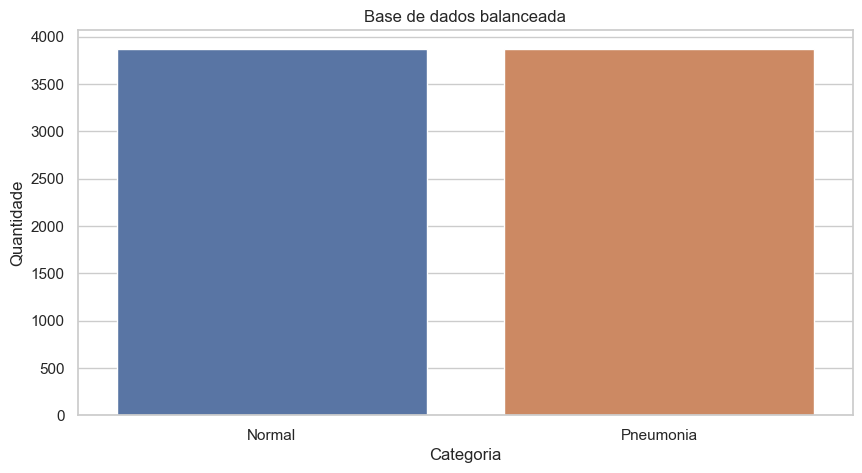

In [16]:
sns.set_theme(style="whitegrid")
fig = plt.subplots(figsize = (10,5))

# Gráfico base treino
sns.barplot(data = quant_dados_new, x = quant_dados_new['Categoria'], y = quant_dados_new['Quantidade'])
plt.title('Base de dados balanceada')

plt.show()

## Separando a base de treino e teste

In [17]:
normal = 'Dados\\chest_xray_balanceado\\xray\\Normal'
pneumonia = 'Dados\\chest_xray_balanceado\\xray\\Pneumonia'

*Os codigos comentados já foram aplicados utilizando funções do script functions_tcc*

In [31]:
# normal_img = [os.path.join(normal, img) for img in os.listdir(normal)]
# pneumo_img = [os.path.join(pneumonia, img) for img in os.listdir(pneumonia)]

In [32]:
#### Fazendo a separação em treino e teste para cada classe com 80% treino e 20% teste
# normal_train, normal_test = train_test_split(normal_img, test_size=1 - 0.8, random_state=81)
# pneumo_train, pneumo_test = train_test_split(pneumo_img, test_size=1 - 0.8, random_state=81)

In [20]:
## Criando as pastas de treino e teste
# os.mkdir('Dados\\chest_xray_balanceado\\train')
# os.mkdir('Dados\\chest_xray_balanceado\\test')

In [30]:
#### Criando as pastas de cada categoria
## Treino -------------------------------------------
# os.mkdir('Dados\\chest_xray_balanceado\\train\\NORMAL')
# os.mkdir('Dados\\chest_xray_balanceado\\train\\PNEUMONIA')

## Teste ---------------------------------------------
# os.mkdir('Dados\\chest_xray_balanceado\\test\\NORMAL')
# os.mkdir('Dados\\chest_xray_balanceado\\test\\Pneumonia')

In [33]:
# def copy_img(path_img, path_fold):
#     for img in range(len(path_img)):
#         shutil.copy(path_img[img], path_fold)

In [35]:
#### Para a classe normal
# copy_img(normal_train,'Dados\\chest_xray_balanceado\\train\\NORMAL')
# copy_img(normal_test,'Dados\\chest_xray_balanceado\\test\\NORMAL')

#### Para a classe Pneumonia
# copy_img(pneumo_train,'Dados\\chest_xray_balanceado\\train\\PNEUMONIA')
# copy_img(pneumo_test,'Dados\\chest_xray_balanceado\\test\\PNEUMONIA')

Verificando algumas imagens da base de treino

In [18]:
img_normal = function_tcc.amostragem('Dados\\chest_xray_balanceado\\train\\NORMAL', n = 1)[0]
img_pneumo = function_tcc.amostragem('Dados\\chest_xray_balanceado\\train\\PNEUMONIA', n = 1)[0]

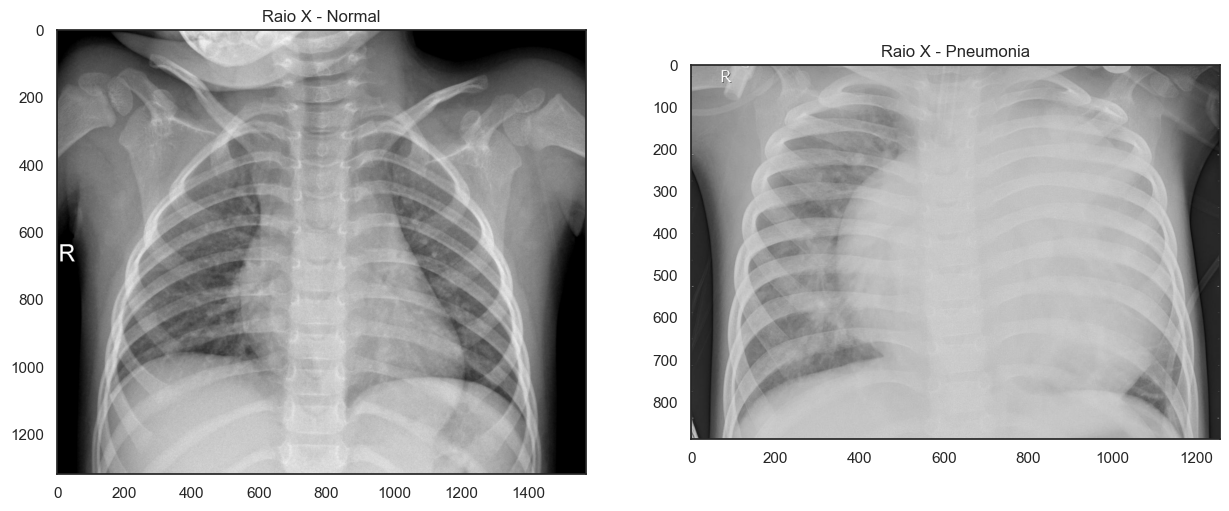

In [19]:
sns.set_theme(style="white")
img_normal = function_tcc.leitura(classe='Normal', img_path=img_normal)
img_pneumo = function_tcc.leitura(classe='Pneumonia', img_path=img_pneumo)

fig, ax = plt.subplots(1,2, figsize = (15,8))

ax[0].imshow(img_normal)
ax[0].set_title('Raio X - Normal')

ax[1].imshow(img_pneumo)
ax[1].set_title('Raio X - Pneumonia')

plt.show()

## Criando as bases de treino e teste


In [20]:
train = 'Dados\\chest_xray_balanceado\\train'
test = 'Dados\\chest_xray_balanceado\\test'
valid = 'Dados\\chest_xray_balanceado\\val'

In [21]:
gerador_treinamento = ImageDataGenerator(
    rescale = 1./255, #normalizar os pixels da imagem
    rotation_range = 7, # será realizado algumas rotações
    horizontal_flip = True, # será realizado rotações na horizontal 
    zoom_range = 0.2
)

gerador_teste = ImageDataGenerator(
    rescale = 1./255
)

gerador_val = ImageDataGenerator(
    rescale = 1./255
)

**Criando datasets específicos para cada CNN utilizada**

> InceptionResNetV2

In [37]:
ds_train_Incep = gerador_treinamento.flow_from_directory(train,
                                                              target_size = (299,299), # redimensionando as imagens
                                                              batch_size = 50,
                                                              class_mode = 'categorical',
                                                              shuffle = True
                                                              )

ds_test_Incep = gerador_teste.flow_from_directory(test,
                                                target_size = (299,299), # redimensionando as imagens
                                                batch_size = 1,
                                                class_mode = 'categorical',
                                                shuffle = False
                                                )

ds_val_Incep= gerador_val.flow_from_directory(valid,
                                                target_size = (299,299), # redimensionando as imagens
                                                batch_size = 1,
                                                class_mode = 'categorical',
                                                shuffle = False
                                                )

Found 7750 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


> VGG16


In [38]:
ds_train_vgg = gerador_treinamento.flow_from_directory(train,
                                                              target_size = (224,224), # redimensionando as imagens
                                                              batch_size = 50,
                                                              class_mode = 'categorical',
                                                              shuffle = True
                                                              )

ds_test_vgg= gerador_teste.flow_from_directory(test,
                                                target_size = (224,224), # redimensionando as imagens
                                                batch_size = 1,
                                                class_mode = 'categorical',
                                                shuffle = False
                                               )

ds_val_vgg= gerador_val.flow_from_directory(valid,
                                                target_size = (224,224), # redimensionando as imagens
                                                batch_size = 1,
                                                class_mode = 'categorical',
                                                shuffle = False
                                                )

Found 7750 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Carregando as arquiteturas de CNN

In [50]:
modelo_Incep = tf.keras.applications.InceptionResNetV2(
    weights='imagenet', # definir os pesos
    include_top=False, # False -> não iremos carregar as camadas densas da rede neural
    input_tensor= Input(shape = (299,299,3)) # dimensão das imagens e numero de canais de cor
)

modelo_VGG = tf.keras.applications.VGG16(
    weights='imagenet', # definir os pesos
    include_top=False, # False -> não iremos carregar as camadas densas da rede neural
    input_tensor= Input(shape = (224,224,3)) # dimensão das imagens e numero de canais de cor
)

**Como o objetivo da utilização do transferlearning é utilizar os pesos já treinados de uma CNN, precisaremos travar as camadas da rede convoluncional das arquiteturas para que neste primeiro mmomento não seja efetuado um retreinamento nos pesos**

In [51]:
# Inception
for layer in modelo_Incep.layers:
    layer.trainable = False 

# VGG16
for layer in modelo_VGG.layers:
    layer.trainable = False 

In [25]:
print('Quantidades de neuronios que iremos utilizar:')
print("Inception: {}".format((modelo_Incep.output.shape[3] + 2)/2))
print("VGG16: {}".format((modelo_VGG.output.shape[3] + 2)/2))

Quantidades de neuronios que iremos utilizar:
Inception: 769.0
VGG16: 257.0


*Para construirmos uma rede neural densa, precisaremos da quantidade de neurônios de saída de cada modelo, logo:*

In [26]:
print("Inception -> Saída: {} -> Entrada na rede neural densa: {} -> Saída: 2".format(modelo_Incep.output.shape[3],(modelo_Incep.output.shape[3] + 2)/2))
print("VGG16 -> Saída: {} -> Entrada na rede neural densa: {} -> Saída: 2".format(modelo_VGG.output.shape[3],(modelo_VGG.output.shape[3] + 2)/2))

Inception -> Saída: 1536 -> Entrada na rede neural densa: 769.0 -> Saída: 2
VGG16 -> Saída: 512 -> Entrada na rede neural densa: 257.0 -> Saída: 2


#### Inception

In [52]:
## Construção da rede neural densa
model_dense = modelo_Incep.output

model_dense= GlobalAveragePooling2D()(model_dense)
model_dense = Dense(units = 769, activation = 'relu')(model_dense)
model_dense = Dropout(rate=0.2)(model_dense)
model_dense = Dense(units = 769, activation = 'relu')(model_dense)
model_dense = Dropout(rate=0.2)(model_dense)

# Camada de saida
model_dense= Dense(units = 2, activation = 'softmax')(model_dense)

In [28]:
## unindo com a base concolucional
RN_Incep = Model(inputs = modelo_Incep.input,
                       outputs = model_dense)

In [29]:
## Compilando a rede neural
RN_Incep.compile(optimizer='Adam', loss='categorical_crossentropy',
                       metrics = ['accuracy'])

> Realizando o Treinamento do modelo Inception-ResNet-V2

In [30]:
## treinando a RN
# historico_Incep = RN_Incep.fit(ds_train_Incep,
                                #   validation_data = ds_val_Incep, epochs=10)

Epoch 1/10
155/155 [==============================] - 238s 1s/step - loss: 0.3028 - accuracy: 0.8803 - val_loss: 0.1835 - val_accuracy: 0.9375
Epoch 2/10
155/155 [==============================] - 172s 1s/step - loss: 0.2026 - accuracy: 0.9223 - val_loss: 0.2765 - val_accuracy: 0.8125
Epoch 3/10
155/155 [==============================] - 168s 1s/step - loss: 0.1825 - accuracy: 0.9292 - val_loss: 0.0941 - val_accuracy: 1.0000
Epoch 4/10
155/155 [==============================] - 171s 1s/step - loss: 0.1763 - accuracy: 0.9332 - val_loss: 0.2305 - val_accuracy: 0.8125
Epoch 5/10
155/155 [==============================] - 169s 1s/step - loss: 0.1633 - accuracy: 0.9385 - val_loss: 0.3126 - val_accuracy: 0.8125
Epoch 6/10
155/155 [==============================] - 169s 1s/step - loss: 0.1613 - accuracy: 0.9417 - val_loss: 0.1485 - val_accuracy: 1.0000
Epoch 7/10
155/155 [==============================] - 171s 1s/step - loss: 0.1506 - accuracy: 0.9432 - val_loss: 0.1046 - val_accuracy: 1.0000

In [55]:
#29m 28.0s

#### VGG16

In [57]:
## Construção da rede neural densa
model_dense = modelo_VGG.output

model_dense= GlobalAveragePooling2D()(model_dense)
model_dense = Dense(units = 257, activation = 'relu')(model_dense)
model_dense = Dropout(rate=0.2)(model_dense)
model_dense = Dense(units = 257, activation = 'relu')(model_dense)
model_dense = Dropout(rate=0.2)(model_dense)

# Camada de saida
model_dense= Dense(units = 2, activation = 'softmax')(model_dense)

In [32]:
RN_VGG = Model(inputs = modelo_VGG.input,
                       outputs = model_dense)

In [33]:
RN_VGG.compile(optimizer='Adam', loss='categorical_crossentropy',
                       metrics = ['accuracy'])

> Realizando o Treinamento do modelo Inception-ResNet-V2

In [34]:
# historico_VGG = RN_VGG.fit(ds_train_vgg,
#                                   validation_data = ds_val_vgg, epochs=10)

Epoch 1/10
155/155 [==============================] - 123s 738ms/step - loss: 0.3495 - accuracy: 0.8477 - val_loss: 0.4923 - val_accuracy: 0.6875
Epoch 2/10
155/155 [==============================] - 114s 733ms/step - loss: 0.2350 - accuracy: 0.9102 - val_loss: 0.6457 - val_accuracy: 0.7500
Epoch 3/10
155/155 [==============================] - 113s 726ms/step - loss: 0.2159 - accuracy: 0.9169 - val_loss: 0.4408 - val_accuracy: 0.7500
Epoch 4/10
155/155 [==============================] - 113s 725ms/step - loss: 0.2037 - accuracy: 0.9225 - val_loss: 0.4094 - val_accuracy: 0.8125
Epoch 5/10
155/155 [==============================] - 113s 726ms/step - loss: 0.2036 - accuracy: 0.9219 - val_loss: 0.5732 - val_accuracy: 0.7500
Epoch 6/10
155/155 [==============================] - 113s 726ms/step - loss: 0.1881 - accuracy: 0.9259 - val_loss: 0.4911 - val_accuracy: 0.8125
Epoch 7/10
155/155 [==============================] - 114s 731ms/step - loss: 0.1848 - accuracy: 0.9299 - val_loss: 0.5596 -

In [54]:
#19m 3.2s

## Salvando o modelo

In [46]:
# os.mkdir('Modelos_2')

> Inception

In [35]:
## Salvando os pesos treinados e o modelo
# function_tcc.save_model(model = RN_Incep, path_save = 'Modelos\\Base Balanceada',
#                         type = 'model', nome = 'Inception_model_B')

# function_tcc.save_model(model = RN_Incep, path_save = 'Modelos\\Base Balanceada',
#                         type = 'weight', nome = 'Inception_weights_B')

In [36]:
# Salvando o histórico
# function_tcc.save_model(model = historico_Incep,path_save = 'Modelos\\Base Balanceada',
#                         type = 'historic', nome = 'historico_incep_B' )

> VGG16

In [37]:
## Salvando os pesos treinados e o modelo
# function_tcc.save_model(model = RN_VGG, path_save = 'Modelos\\Base Balanceada',
#                         type = 'model', nome = 'VGG_model_B')

# function_tcc.save_model(model = RN_VGG, path_save = 'Modelos\\Base Balanceada',
#                         type = 'weight', nome = 'VGG_weights_B')

In [38]:
# Salvando o histórico
# function_tcc.save_model(model = historico_VGG,path_save = 'Modelos\\Base Balanceada',
#                         type = 'historic', nome = 'historico_vgg_B' )

## Carregando os Modelos e pesos já salvos

> Inception

In [22]:
## Carregando o histórico de treinamen
historico_Incep_B = function_tcc.load_model(path_load = 'Modelos\\Base Balanceada\\historico_incep_B.pickle',
                                          type = 'historic')

In [23]:
## Carregando o modelo e os pesos
RN_inception_loaded_B = function_tcc.load_model(path_load = 'Modelos\\Base Balanceada\\Inception_model_B.json',
                                              weight_ph = 'Modelos\\Base Balanceada\\Inception_weights_B.hdf5',
                                              type = 'model')

In [24]:
RN_inception_loaded_B.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

> VGG16

In [25]:
## Carregando o histórico de treinamento
historico_VGG_B = function_tcc.load_model(path_load = 'Modelos\\Base Balanceada\\historico_vgg_B.pickle',
                                          type = 'historic')

In [26]:
## Carregando o modelo e os pesos
RN_vgg_loaded_B = function_tcc.load_model(path_load = 'Modelos\\Base Balanceada\\VGG_model_B.json',
                                              weight_ph = 'Modelos\\Base Balanceada\\VGG_weights_B.hdf5',
                                              type = 'model')

In [27]:
RN_vgg_loaded_B.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Avaliação dos modelos

In [28]:
### acurácia
acc_incp = historico_Incep_B['accuracy']
acc_vgg = historico_VGG_B['accuracy']

val_acc_incep = historico_Incep_B['val_accuracy']
val_acc_vgg = historico_VGG_B['val_accuracy']

### Erro
loss_incp = historico_Incep_B['loss']
loss_vgg = historico_VGG_B['loss']

loss_val_incp = historico_Incep_B['val_loss']
loss_val_vgg = historico_VGG_B['val_loss']

> Curva de aprendizagem para o modelo Inception-ResNet-V2

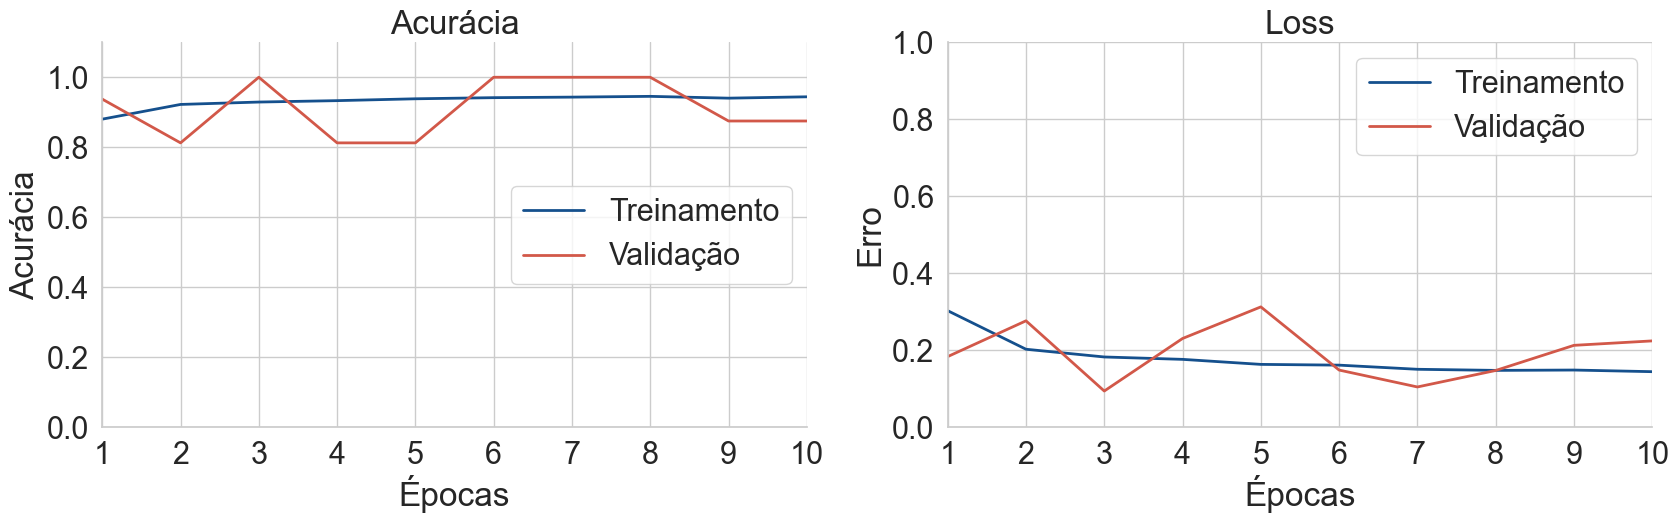

In [31]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params, 
              palette=color_pallete[0], font_scale=2)
#sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(1,2, figsize = (20,5))

# incep
sns.lineplot(acc_incp, label='Treinamento',ax = ax[0], linewidth = 2)
sns.lineplot(val_acc_incep, label='Validação',ax = ax[0], linewidth = 2)
ax[0].set_ylim([0,1.1])
ax[0].set_xlim([0,9])
ax[0].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[0].legend(loc='center right') 
ax[0].set_title("Acurácia")
ax[0].set_xlabel("Épocas")
ax[0].set_ylabel("Acurácia")

# incep
sns.lineplot(loss_incp, label='Treinamento',ax = ax[1], linewidth = 2)
sns.lineplot(loss_val_incp, label='Validação',ax = ax[1], linewidth = 2)

ax[1].set_ylim([0,1])
ax[1].set_xlim([0,9])
ax[1].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[1].legend(loc='upper right') 
ax[1].set_title("Loss")
ax[1].set_xlabel("Épocas")
ax[1].set_ylabel("Erro")

plt.show()

> Curva de aprendizagem para o modelo VGG-16

Text(0, 0.5, 'Erro')

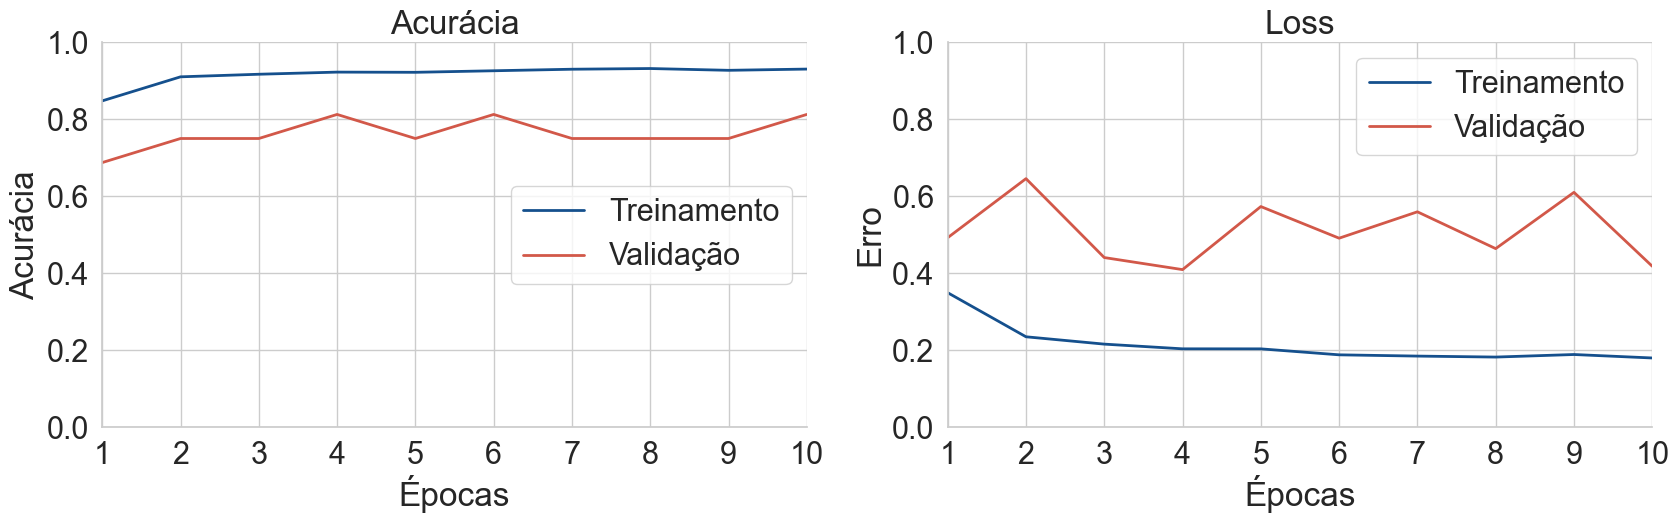

In [32]:
fig, ax = plt.subplots(1,2, figsize = (20,5))

# vgg
sns.lineplot(acc_vgg, label='Treinamento',ax = ax[0], linewidth = 2)
sns.lineplot(val_acc_vgg, label='Validação',ax = ax[0], linewidth = 2)
ax[0].set_ylim([0,1])
ax[0].set_xlim([0,9])
ax[0].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[0].legend(loc='center right') 
ax[0].set_title("Acurácia")
ax[0].set_xlabel("Épocas")
ax[0].set_ylabel("Acurácia")


# vgg
sns.lineplot(loss_vgg, label='Treinamento',ax = ax[1], linewidth = 2)
sns.lineplot(loss_val_vgg, label='Validação',ax = ax[1], linewidth = 2)

ax[1].set_ylim([0,1])
ax[1].set_xlim([0,9])
ax[1].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[1].legend(loc='upper right') 
ax[1].set_title("Loss")
ax[1].set_xlabel("Épocas")
ax[1].set_ylabel("Erro")

> Comparaçao da curva de aprendizagem entre os dois modelos

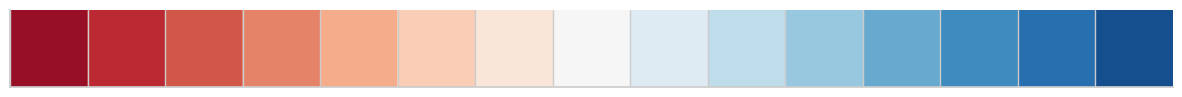

In [33]:
colors = sns.color_palette("RdBu", 15)
sns.palplot(colors)

color_pallete = []
color_pallete.append([colors[14],colors[2]])

Text(0, 0.5, 'Erro')

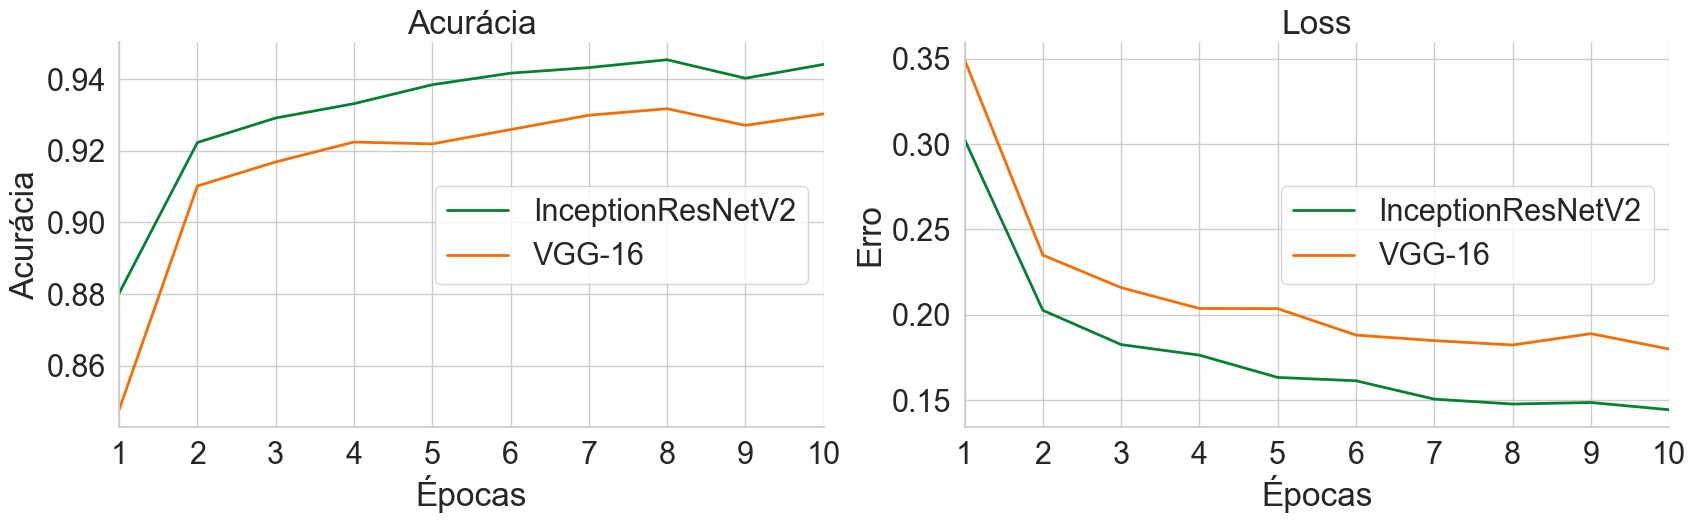

In [35]:
acc_incp = historico_Incep_B['accuracy']
acc_vgg = historico_VGG_B['accuracy']

loss_incp = historico_Incep_B['loss']
loss_vgg = historico_VGG_B['loss']

sns.set_theme(style="whitegrid", rc=custom_params, 
              palette=["#058032","#f56d05"], font_scale=2)

fig, ax = plt.subplots(1,2, figsize = (20,5))

# incep
sns.lineplot(acc_incp, label='InceptionResNetV2',ax = ax[0], linewidth = 2)
sns.lineplot(acc_vgg, label='VGG-16',ax = ax[0], linewidth = 2)
# ax[0].set_ylim([0,1])
ax[0].set_xlim([0,9])
ax[0].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[0].legend(loc='center right') 
ax[0].set_title("Acurácia")
ax[0].set_xlabel("Épocas")
ax[0].set_ylabel("Acurácia")

# vgg
sns.lineplot(loss_incp, label='InceptionResNetV2',ax = ax[1], linewidth = 2)
sns.lineplot(loss_vgg, label='VGG-16',ax = ax[1], linewidth = 2)

# ax[1].set_ylim([0,1])
ax[1].set_xlim([0,9])
ax[1].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[1].legend(loc='center right') 
ax[1].set_title("Loss")
ax[1].set_xlabel("Épocas")
ax[1].set_ylabel("Erro")

## Classificação

In [39]:
prev_incep_1 = RN_inception_loaded_B.predict(ds_test_Incep)
prev_incep = np.argmax(prev_incep_1, axis = 1)

prev_vgg_1 = RN_vgg_loaded_B.predict(ds_test_vgg)
prev_vgg = np.argmax(prev_vgg_1, axis = 1)

624/624 [==============================] - 9s 12ms/step


> Definindo as cores a serem utilizadas

In [40]:
color_pallete2 = []
color_pallete2.append([colors[6],colors[14],colors[2]])
color_pallete2[0]

[(0.9829296424452134, 0.9018838908112264, 0.8542099192618224),
 (0.08419838523644753, 0.31280276816609, 0.5534025374855824),
 (0.8226066897347174, 0.34325259515570933, 0.28627450980392155)]

> Matriz de Confusão

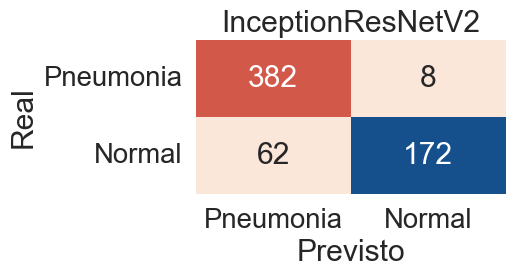

In [42]:
label = ['Pneumonia', "Normal"]
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.8)
fig, ax = plt.subplots(figsize = (4,2))

cm_1 = confusion_matrix(ds_test_Incep.classes, prev_incep,labels=[1,0])
sns.heatmap(cm_1, annot=True,fmt='d', 
            xticklabels=label, yticklabels=label,cmap=color_pallete2[0], cbar=False)
ax.set_xlabel("Previsto")
ax.set_title("InceptionResNetV2")
ax.set_ylabel("Real")
plt.show()

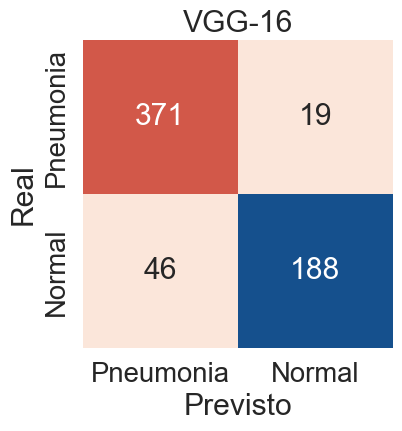

In [43]:
label = ['Pneumonia', "Normal"]
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.8)
fig, ax = plt.subplots(figsize = (4,4))

cm_2 = confusion_matrix(ds_test_vgg.classes, prev_vgg,labels=[1,0])
sns.heatmap(cm_2, annot=True,fmt='d', xticklabels=label, 
            yticklabels=label,cmap=color_pallete2[0], cbar=False)
ax.set_xlabel("Previsto")
ax.set_title("VGG-16")
ax.set_ylabel("Real")

plt.show()

> Visualização das métricas de avaliação pelo Classification Report

In [45]:
print('-------------------------------------------------------')
print('>>>>>>>>>>>>>>> Classification Report <<<<<<<<<<<<<<<<<')
print('-------------------------------------------------------')
print('----------------> InceptionResNetV2 <------------------')
print(classification_report(ds_test_Incep.classes, prev_incep,
                            target_names=label,labels=[1,0]))
print('-------------------------------------------------------')

print('----------------------> VGG16 <------------------------')
print(classification_report(ds_test_vgg.classes, prev_vgg,
                            target_names=label,labels=[1,0]))
print('-------------------------------------------------------')

-------------------------------------------------------
>>>>>>>>>>>>>>> Classification Report <<<<<<<<<<<<<<<<<
-------------------------------------------------------
----------------> InceptionResNetV2 <------------------
              precision    recall  f1-score   support

   Pneumonia       0.86      0.98      0.92       390
      Normal       0.96      0.74      0.83       234

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.87       624
weighted avg       0.90      0.89      0.88       624

-------------------------------------------------------
----------------------> VGG16 <------------------------
              precision    recall  f1-score   support

   Pneumonia       0.89      0.95      0.92       390
      Normal       0.91      0.80      0.85       234

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.89       624

----------

#### Curva ROC e a Curva de Precision-Recall


> **fpr**: *False positive rate* \
> **tpr**: *True positive rate*

In [46]:
fpr_inc, tpr_inc, _ = roc_curve(ds_test_Incep.classes, prev_incep)
fpr_vgg, tpr_vgg, _ = roc_curve(ds_test_vgg.classes, prev_vgg)

roc_auc_inc = auc(fpr_inc, tpr_inc)
roc_auc_vgg = auc(fpr_vgg, tpr_vgg)

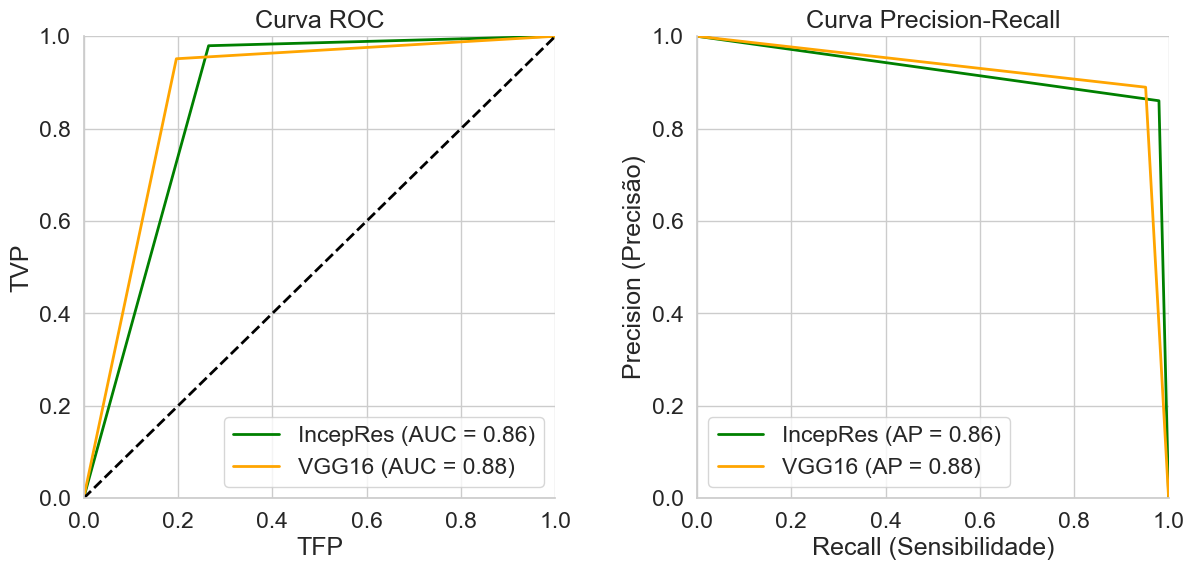

In [48]:
precision, recall, thresholds = precision_recall_curve(ds_test_Incep.classes, prev_incep)
precision2, recall2, thresholds2 = precision_recall_curve(ds_test_vgg.classes, prev_vgg)

precision[0] = 0
precision2[0] = 0

ap_incep = average_precision_score(ds_test_Incep.classes, prev_incep)
ap_vgg = average_precision_score(ds_test_vgg.classes, prev_vgg)

sns.set_theme(style="whitegrid", rc=custom_params, 
              palette=["Green","Orange"], font_scale=1.5)

fig, ax = plt.subplots(1,2, figsize = (14,6))
plt.subplots_adjust(wspace=0.3)

ax[0].plot(fpr_inc, tpr_inc, lw=2, label='IncepRes (AUC = %0.2f)' % roc_auc_inc)
ax[0].plot(fpr_vgg, tpr_vgg, lw=2, label='VGG16 (AUC = %0.2f)' % roc_auc_vgg)
ax[0].plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
ax[0].set_xlabel('TFP')
ax[0].set_ylabel('TVP')
ax[0].set_title('Curva ROC')
ax[0].legend(loc="lower right")
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])

# Plota a curva de precisão e recall
ax[1].plot(recall, precision, label = 'IncepRes (AP = %.2f)' % ap_incep, lw =2)
ax[1].plot(recall2, precision2,label = 'VGG16 (AP = %.2f)' % ap_vgg, lw =2)
ax[1].set_xlabel('Recall (Sensibilidade)')
ax[1].set_ylabel('Precision (Precisão)')
ax[1].set_title('Curva Precision-Recall')
# ax[1].grid(True)
ax[1].legend(loc="lower left")
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])


plt.show()

## Fine tuning


**Neste caso será aplicado o *Shallow fin-tuned* um tipo de ajuste fino (fine tunning) em que as camadas finais da parte convolucional serão retreinadas com os dados da base atual.**

*Para a aplicação deste método foi estabelecido que apenas 25% das últimas camadas da parte convolucional, de cada um dos modelos, foram retreinados.**

In [52]:
len(modelo_Incep.layers), len(modelo_VGG.layers)

(780, 19)

In [53]:
# Inception
for layer in modelo_Incep.layers:
    layer.trainable = True 

# VGG16
for layer in modelo_VGG.layers:
    layer.trainable = True 

> Aplicando Finetuning na inception

In [54]:
780 - 780*0.25

585.0

In [55]:
fine_tuning_at = 585

In [56]:
for layer in modelo_Incep.layers[:fine_tuning_at]:
    layer.trainable = False

In [57]:
for layer in  modelo_Incep.layers:
    print(layer, layer.trainable )

<keras.engine.input_layer.InputLayer object at 0x00000276C6711B10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000276C669A3E0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x00000276C669A350> False
<keras.layers.core.activation.Activation object at 0x00000276C6712650> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000276C669BFD0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000027724AC0AF0> False
<keras.layers.core.activation.Activation object at 0x0000027589E76290> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000027724A8A890> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x00000276C6699840> False
<keras.layers.core.activation.Activation object at 0x0000027589DCFF10> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000276C6699750> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000276C66988

> Aplicando Finetuning no modelo VGG-16

In [58]:
### treinaremos 25% da vgg
19 -19*0.25

14.25

In [59]:
modelo_VGG.layers

In [60]:
fine_tuning_at = 14

In [61]:
for layer  in modelo_VGG.layers[:fine_tuning_at]:
    layer.trainable = False

In [62]:
for layer in  modelo_VGG.layers:
    print(layer, layer.trainable )

<keras.engine.input_layer.InputLayer object at 0x00000276C6712830> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000276C7BF43D0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000275F6C79870> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002758C7ACF10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002758C90B5E0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002758C9D00D0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002758C9D2FB0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002758C7AE6B0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002758C9D3DF0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002758C7AD690> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002758C7AF610> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002758C7ADD80> False
<keras.layers.convolutional.conv2d.Conv2D object

### Realizando o Treinamento

> Inception-ResNet-V2

In [53]:
RN_Incep_FT = Model(inputs = modelo_Incep.input,
                       outputs = model_dense)

In [56]:
## Compilando a rede neural
RN_Incep_FT.compile(optimizer='Adam', loss='categorical_crossentropy',
                       metrics = ['accuracy'])

historico_Incep = RN_Incep_FT.fit(ds_train_Incep,
                                  validation_data = ds_val_Incep, epochs=10)

Epoch 1/10
155/155 [==============================] - 244s 1s/step - loss: 0.1934 - accuracy: 0.9303 - val_loss: 0.6499 - val_accuracy: 0.9375
Epoch 2/10
155/155 [==============================] - 164s 1s/step - loss: 0.0958 - accuracy: 0.9679 - val_loss: 0.9472 - val_accuracy: 0.6250
Epoch 3/10
155/155 [==============================] - 164s 1s/step - loss: 0.0761 - accuracy: 0.9737 - val_loss: 0.0994 - val_accuracy: 0.9375
Epoch 4/10
155/155 [==============================] - 164s 1s/step - loss: 0.0626 - accuracy: 0.9806 - val_loss: 0.0971 - val_accuracy: 0.9375
Epoch 5/10
155/155 [==============================] - 164s 1s/step - loss: 0.0610 - accuracy: 0.9788 - val_loss: 0.5106 - val_accuracy: 0.6875
Epoch 6/10
155/155 [==============================] - 165s 1s/step - loss: 0.0494 - accuracy: 0.9827 - val_loss: 2.2482 - val_accuracy: 0.6250
Epoch 7/10
155/155 [==============================] - 164s 1s/step - loss: 0.0473 - accuracy: 0.9844 - val_loss: 0.1288 - val_accuracy: 0.8750

> VGG-16

In [58]:
RN_VGG_FT = Model(inputs = modelo_VGG.input,
                       outputs = model_dense)

In [59]:
RN_VGG_FT.compile(optimizer='Adam', loss='categorical_crossentropy',
                       metrics = ['accuracy'])

historico_VGG = RN_VGG_FT.fit(ds_train_vgg,
                                  validation_data = ds_val_vgg, epochs=10)

Epoch 1/10
155/155 [==============================] - 121s 722ms/step - loss: 0.3588 - accuracy: 0.8345 - val_loss: 0.2844 - val_accuracy: 0.8750
Epoch 2/10
155/155 [==============================] - 111s 716ms/step - loss: 0.1742 - accuracy: 0.9351 - val_loss: 0.4052 - val_accuracy: 0.8125
Epoch 3/10
155/155 [==============================] - 111s 717ms/step - loss: 0.1272 - accuracy: 0.9535 - val_loss: 0.1567 - val_accuracy: 0.9375
Epoch 4/10
155/155 [==============================] - 112s 721ms/step - loss: 0.1104 - accuracy: 0.9577 - val_loss: 0.2864 - val_accuracy: 0.8750
Epoch 5/10
155/155 [==============================] - 112s 724ms/step - loss: 0.0940 - accuracy: 0.9646 - val_loss: 0.1820 - val_accuracy: 0.9375
Epoch 6/10
155/155 [==============================] - 113s 730ms/step - loss: 0.0918 - accuracy: 0.9667 - val_loss: 0.1901 - val_accuracy: 0.8750
Epoch 7/10
155/155 [==============================] - 112s 719ms/step - loss: 0.0926 - accuracy: 0.9681 - val_loss: 0.1161 -

### Salvando os modelos

> Inception

In [61]:
## Salvando os pesos treinados e o modelo
function_tcc.save_model(model = RN_Incep_FT, path_save = 'Modelos\\Base Balanceada',
                        type = 'model', nome = 'Inception_model_B_FT')

function_tcc.save_model(model = RN_Incep_FT, path_save = 'Modelos\\Base Balanceada',
                        type = 'weight', nome = 'Inception_weights_B_FT')

## Salvando o histórico
function_tcc.save_model(model = historico_Incep,path_save = 'Modelos\\Base Balanceada',
                        type = 'historic', nome = 'historico_incep_B_FT' )

> VGG

In [62]:
## Salvando os pesos treinados e o modelo
function_tcc.save_model(model = RN_VGG_FT, path_save = 'Modelos\\Base Balanceada',
                        type = 'model', nome = 'VGG_model_B_FT')

function_tcc.save_model(model = RN_VGG_FT, path_save = 'Modelos\\Base Balanceada',
                        type = 'weight', nome = 'VGG_weights_B_FT')

## Salvando o histórico
function_tcc.save_model(model = historico_VGG,path_save = 'Modelos\\Base Balanceada',
                        type = 'historic', nome = 'historico_vgg_B_FT' )

### Carregando os Modelos e pesos já salvos

> Inception

In [63]:
## Carregando o histórico de treinamento
historico_Incep_B_FT = function_tcc.load_model(path_load = 'Modelos\\Base Balanceada\\historico_incep_B_FT.pickle',
                                          type = 'historic')

## Carregando o modelo e os pesos
RN_inception_loaded_B_FT = function_tcc.load_model(path_load = 'Modelos\\Base Balanceada\\Inception_model_B_FT.json',
                                              weight_ph = 'Modelos\\Base Balanceada\\Inception_weights_B_FT.hdf5',
                                              type = 'model')

RN_inception_loaded_B_FT.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

> VGG

In [64]:
## Carregando o histórico de treinamento
historico_VGG_B_FT = function_tcc.load_model(path_load = 'Modelos\\Base Balanceada\\historico_vgg_B_FT.pickle',
                                          type = 'historic')

## Carregando o modelo e os pesos
RN_vgg_loaded_B_FT = function_tcc.load_model(path_load = 'Modelos\\Base Balanceada\\VGG_model_B_FT.json',
                                              weight_ph = 'Modelos\\Base Balanceada\\VGG_weights_B_FT.hdf5',
                                              type = 'model')

RN_vgg_loaded_B_FT.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Avaliação dos Modelos

In [65]:
### acurácia
acc_incp = historico_Incep_B_FT['accuracy']
acc_vgg = historico_VGG_B_FT['accuracy']

val_acc_incep = historico_Incep_B_FT['val_accuracy']
val_acc_vgg = historico_VGG_B_FT['val_accuracy']

### Erro
loss_incp = historico_Incep_B_FT['loss']
loss_vgg = historico_VGG_B_FT['loss']

loss_val_incp = historico_Incep_B_FT['val_loss']
loss_val_vgg = historico_VGG_B_FT['val_loss']

> Transformando a saída dos valores decimais no formato pt-Br

In [66]:
#### Configurar a localidade para o Brasil (pt_BR)
locale.setlocale(locale.LC_ALL, 'pt_BR')

####
def format_decimais(value, _):
    return locale.format_string("%.2f", value, grouping=True)

> Curva de aprendizado para o modelo da Inception-ResNet-V2

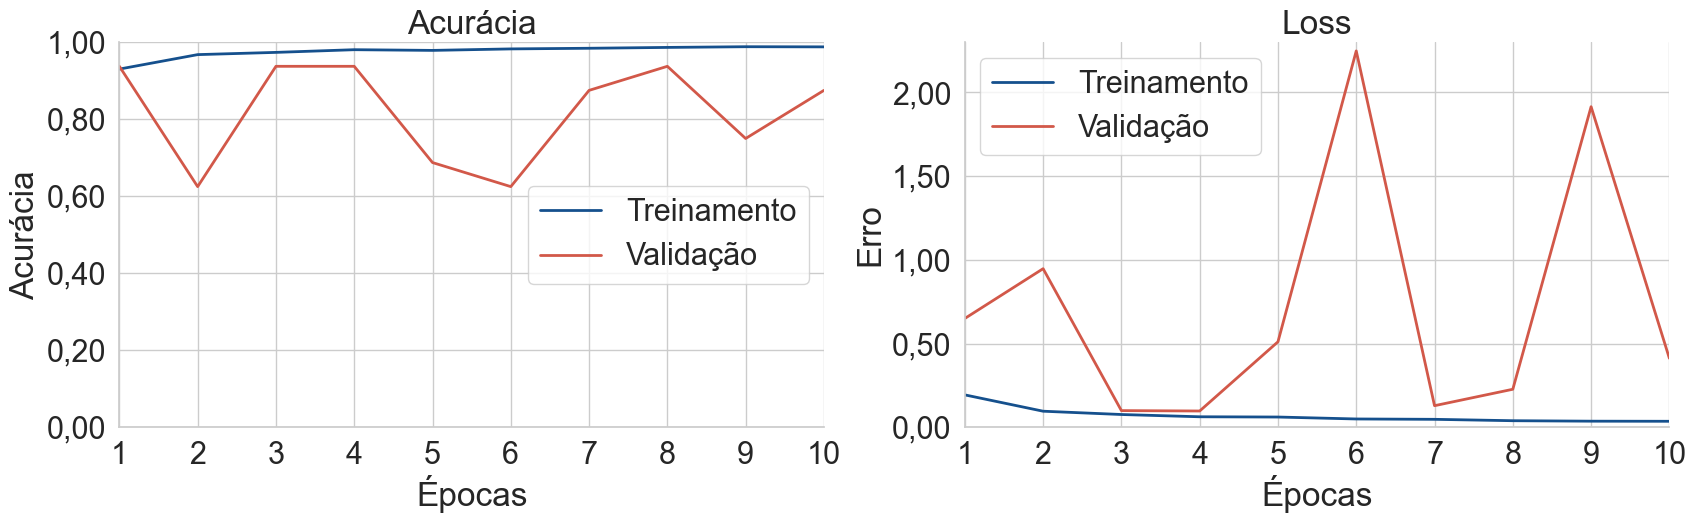

In [68]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params, 
              palette=color_pallete[0], font_scale=2)
#sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(1,2, figsize = (20,5))

# incep
sns.lineplot(acc_incp, label='Treinamento',ax = ax[0], linewidth = 2)
sns.lineplot(val_acc_incep, label='Validação',ax = ax[0], linewidth = 2)
ax[0].set_ylim([0,1])
ax[0].set_xlim([0,9])
ax[0].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[0].legend(loc='center right') 
ax[0].set_title("Acurácia")
ax[0].set_xlabel("Épocas")
ax[0].set_ylabel("Acurácia")
ax[0].yaxis.set_major_formatter(FuncFormatter(format_decimais))

# incep
sns.lineplot(loss_incp, label='Treinamento',ax = ax[1], linewidth = 2)
sns.lineplot(loss_val_incp, label='Validação',ax = ax[1], linewidth = 2)

ax[1].set_ylim([0,2.30])
ax[1].set_xlim([0,9])
ax[1].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[1].legend(loc='upper left') 
ax[1].set_title("Loss")
ax[1].set_xlabel("Épocas")
ax[1].set_ylabel("Erro")
ax[1].yaxis.set_major_formatter(FuncFormatter(format_decimais))

plt.show()

> Curva de aprendizado para o modelo VGG-16

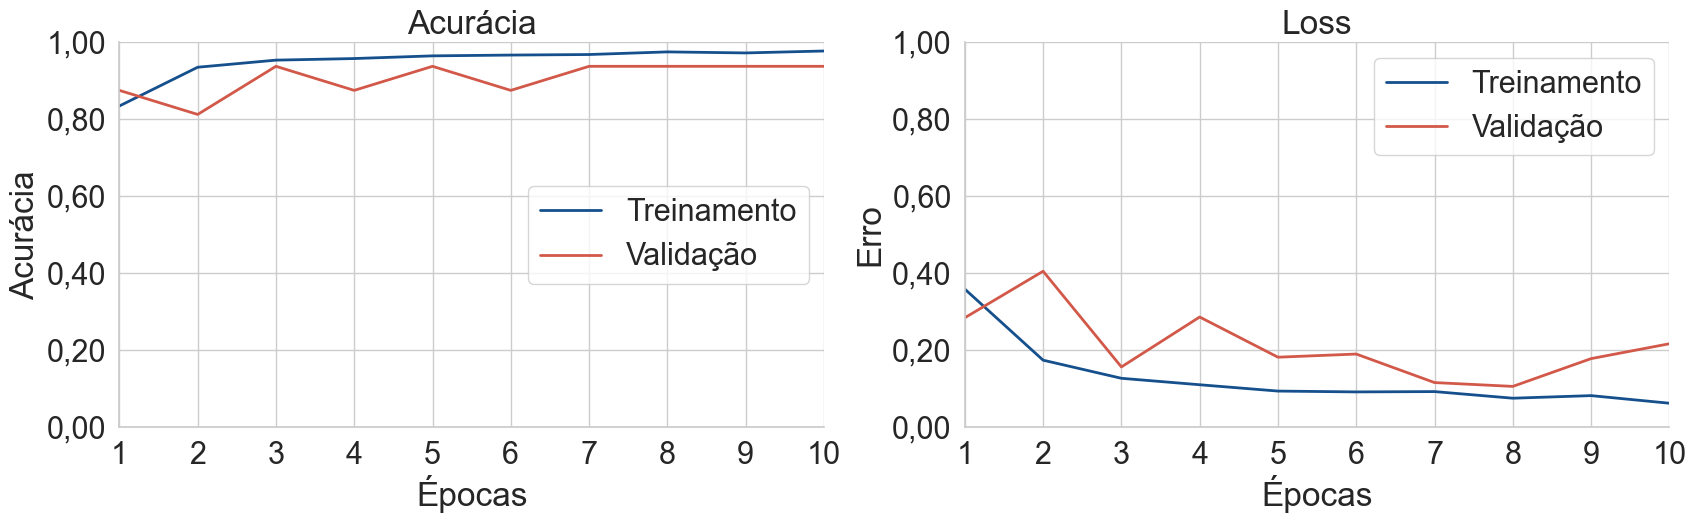

In [70]:
fig, ax = plt.subplots(1,2, figsize = (20,5))

# vgg
sns.lineplot(acc_vgg, label='Treinamento',ax = ax[0], linewidth = 2)
sns.lineplot(val_acc_vgg, label='Validação',ax = ax[0], linewidth = 2)
ax[0].set_ylim([0,1])
ax[0].set_xlim([0,9])
ax[0].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[0].legend(loc='center right') 
ax[0].set_title("Acurácia")
ax[0].set_xlabel("Épocas")
ax[0].set_ylabel("Acurácia")
ax[0].yaxis.set_major_formatter(FuncFormatter(format_decimais))


# vgg
sns.lineplot(loss_vgg, label='Treinamento',ax = ax[1], linewidth = 2)
sns.lineplot(loss_val_vgg, label='Validação',ax = ax[1], linewidth = 2)

ax[1].set_ylim([0,1])
ax[1].set_xlim([0,9])
ax[1].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[1].legend(loc='upper right') 
ax[1].set_title("Loss")
ax[1].set_xlabel("Épocas")
ax[1].set_ylabel("Erro")
ax[1].yaxis.set_major_formatter(FuncFormatter(format_decimais))

> Comparação da curva de aprendizagem entre ambos os modelos

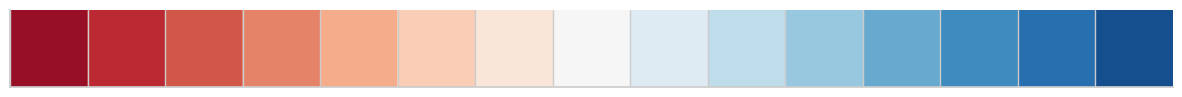

In [71]:
colors = sns.color_palette("RdBu", 15)
sns.palplot(colors)

color_pallete = []
color_pallete.append([colors[14],colors[2]])

Text(0, 0.5, 'Erro')

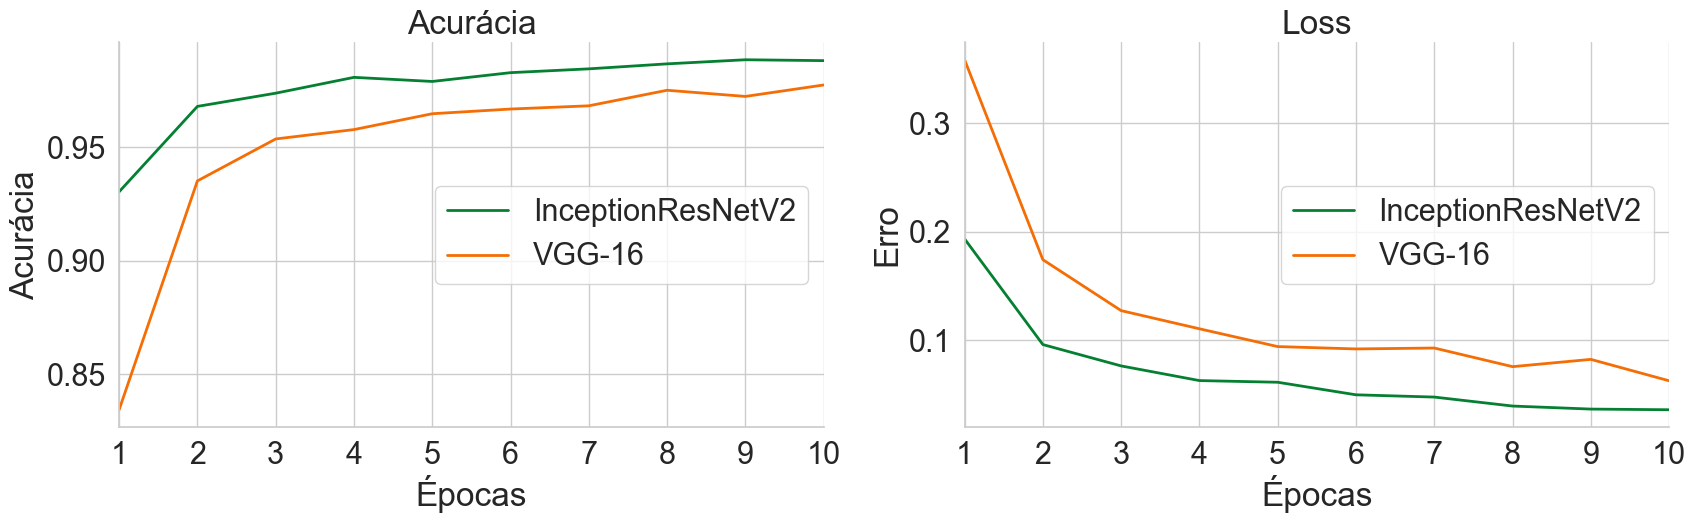

In [72]:
sns.set_theme(style="whitegrid", rc=custom_params, 
              palette=["#058032","#f56d05"], font_scale=2)

fig, ax = plt.subplots(1,2, figsize = (20,5))

# incep
sns.lineplot(acc_incp, label='InceptionResNetV2',ax = ax[0], linewidth = 2)
sns.lineplot(acc_vgg, label='VGG-16',ax = ax[0], linewidth = 2)
# ax[0].set_ylim([0,1])
ax[0].set_xlim([0,9])
ax[0].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[0].legend(loc='center right') 
ax[0].set_title("Acurácia")
ax[0].set_xlabel("Épocas")
ax[0].set_ylabel("Acurácia")

# vgg
sns.lineplot(loss_incp, label='InceptionResNetV2',ax = ax[1], linewidth = 2)
sns.lineplot(loss_vgg, label='VGG-16',ax = ax[1], linewidth = 2)

# ax[1].set_ylim([0,1])
ax[1].set_xlim([0,9])
ax[1].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[1].legend(loc='center right') 
ax[1].set_title("Loss")
ax[1].set_xlabel("Épocas")
ax[1].set_ylabel("Erro")

### Classificação

In [73]:
prev_incep_1 = RN_inception_loaded_B_FT.predict(ds_test_Incep)
prev_incep = np.argmax(prev_incep_1, axis = 1)

prev_vgg_1 = RN_vgg_loaded_B_FT.predict(ds_test_vgg)
prev_vgg = np.argmax(prev_vgg_1, axis = 1)

624/624 [==============================] - 8s 12ms/step


In [74]:
color_pallete2 = []
color_pallete2.append([colors[6],colors[14],colors[2]])
color_pallete2[0]

[(0.9829296424452134, 0.9018838908112264, 0.8542099192618224),
 (0.08419838523644753, 0.31280276816609, 0.5534025374855824),
 (0.8226066897347174, 0.34325259515570933, 0.28627450980392155)]

> Matriz de confusão

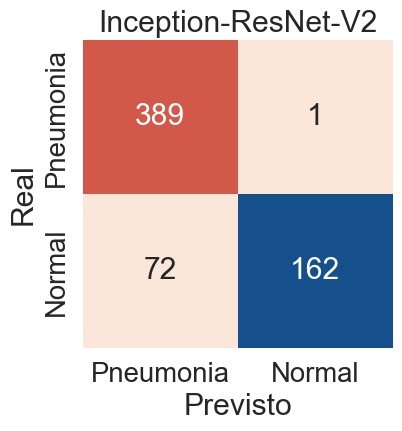

In [75]:
label = ['Pneumonia', "Normal"]
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.8)
fig, ax = plt.subplots(figsize = (4,4))

cm_1 = confusion_matrix(ds_test_Incep.classes, prev_incep,labels=[1,0])
sns.heatmap(cm_1, annot=True,fmt='d', 
            xticklabels=label, yticklabels=label,cmap=color_pallete2[0], cbar=False)
ax.set_xlabel("Previsto")
ax.set_title("Inception-ResNet-V2")
ax.set_ylabel("Real")
plt.show()

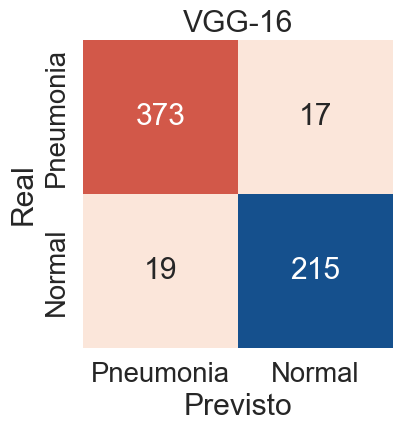

In [76]:
label = ['Pneumonia', "Normal"]
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.8)
fig, ax = plt.subplots(figsize = (4,4))

cm_2 = confusion_matrix(ds_test_vgg.classes, prev_vgg,labels=[1,0])
sns.heatmap(cm_2, annot=True,fmt='d', xticklabels=label, 
            yticklabels=label,cmap=color_pallete2[0], cbar=False)
ax.set_xlabel("Previsto")
ax.set_title("VGG-16")
ax.set_ylabel("Real")

plt.show()

> Visualização das métricas de avaliação pelo Classification Report

In [78]:
print('-------------------------------------------------------')
print('>>>>>>>>>>>>>>> Classification Report <<<<<<<<<<<<<<<<<')
print('-------------------------------------------------------')
print('----------------> InceptionResNetV2 <------------------')
print(classification_report(ds_test_Incep.classes, prev_incep,
                            target_names=label,labels=[1,0]))
print('-------------------------------------------------------')

print('----------------------> VGG16 <------------------------')
print(classification_report(ds_test_vgg.classes, prev_vgg,
                            target_names=label,labels=[1,0]))
print('-------------------------------------------------------')

-------------------------------------------------------
>>>>>>>>>>>>>>> Classification Report <<<<<<<<<<<<<<<<<
-------------------------------------------------------
----------------> InceptionResNetV2 <------------------
              precision    recall  f1-score   support

   Pneumonia       0.84      1.00      0.91       390
      Normal       0.99      0.69      0.82       234

    accuracy                           0.88       624
   macro avg       0.92      0.84      0.87       624
weighted avg       0.90      0.88      0.88       624

-------------------------------------------------------
----------------------> VGG16 <------------------------
              precision    recall  f1-score   support

   Pneumonia       0.95      0.96      0.95       390
      Normal       0.93      0.92      0.92       234

    accuracy                           0.94       624
   macro avg       0.94      0.94      0.94       624
weighted avg       0.94      0.94      0.94       624

----------

### Curva ROC e a Curva Precision-Recall

In [79]:
fpr_inc, tpr_inc, _ = roc_curve(ds_test_Incep.classes, prev_incep)
fpr_vgg, tpr_vgg, _ = roc_curve(ds_test_vgg.classes, prev_vgg)

roc_auc_inc = auc(fpr_inc, tpr_inc)
roc_auc_vgg = auc(fpr_vgg, tpr_vgg)

C:\Users\giull\AppData\Local\Temp\ipykernel_22024\2220974248.py:16: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  ax[0].plot(fpr_inc, tpr_inc, lw=2, label='IncepRes (AUC = %s)' % locale.format("%.2f",roc_auc_inc))
C:\Users\giull\AppData\Local\Temp\ipykernel_22024\2220974248.py:17: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  ax[0].plot(fpr_vgg, tpr_vgg, lw=2, label='VGG16 (AUC = %s)' % locale.format("%.2f",roc_auc_vgg))
C:\Users\giull\AppData\Local\Temp\ipykernel_22024\2220974248.py:29: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  ax[1].plot(recall, precision, label = 'IncepRes (AP = %s)' % locale.format("%.2f",ap_incep), lw =2)
C:\Users\giull\AppData\Local\Temp\ipykernel_22024\2220974248.py:30: DeprecationWarning: This method will be removed in a future version of Pyt

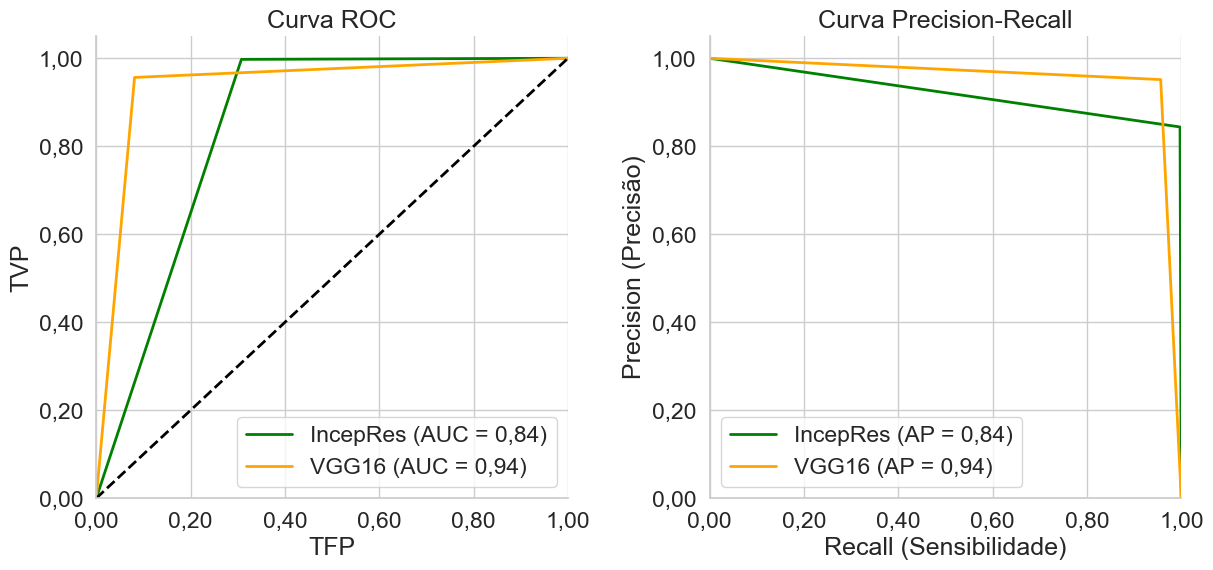

In [81]:
precision, recall, thresholds = precision_recall_curve(ds_test_Incep.classes, prev_incep)
precision2, recall2, thresholds2 = precision_recall_curve(ds_test_vgg.classes, prev_vgg)

precision[0] = 0
precision2[0] = 0

ap_incep = average_precision_score(ds_test_Incep.classes, prev_incep)
ap_vgg = average_precision_score(ds_test_vgg.classes, prev_vgg)

sns.set_theme(style="whitegrid", rc=custom_params, 
              palette=["Green","Orange"], font_scale=1.5)

fig, ax = plt.subplots(1,2, figsize = (14,6))
plt.subplots_adjust(wspace=0.3)

ax[0].plot(fpr_inc, tpr_inc, lw=2, label='IncepRes (AUC = %s)' % locale.format("%.2f",roc_auc_inc))
ax[0].plot(fpr_vgg, tpr_vgg, lw=2, label='VGG16 (AUC = %s)' % locale.format("%.2f",roc_auc_vgg))
ax[0].plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
ax[0].set_xlabel('TFP')
ax[0].set_ylabel('TVP')
ax[0].set_title('Curva ROC')
ax[0].legend(loc="lower right")
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1.05])
ax[0].yaxis.set_major_formatter(FuncFormatter(format_decimais))
ax[0].xaxis.set_major_formatter(FuncFormatter(format_decimais))

# Plota a curva de precisão e recall
ax[1].plot(recall, precision, label = 'IncepRes (AP = %s)' % locale.format("%.2f",ap_incep), lw =2)
ax[1].plot(recall2, precision2,label = 'VGG16 (AP = %s)' % locale.format("%.2f",ap_vgg), lw =2)
ax[1].set_xlabel('Recall (Sensibilidade)')
ax[1].set_ylabel('Precision (Precisão)')
ax[1].set_title('Curva Precision-Recall')
# ax[1].grid(True)
ax[1].legend(loc="lower left")
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1.05])
ax[1].yaxis.set_major_formatter(FuncFormatter(format_decimais))
ax[1].xaxis.set_major_formatter(FuncFormatter(format_decimais))


plt.show()